In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import uproot
import awkward as ak

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Neural Positive Reweighting

In the `E906` data analysis, we employ the event mixing method [arXiv:2302.04152 [hep-ex]](https://arxiv.org/abs/2302.04152) to estimate the combinatorial background. This method involves assigning negative weights to the background events. In this particular example, we calculate the weights for simulated Monte Carlo (MC) events that closely approximate the characteristics of the `E906` data. The details of this method are explained in [arXiv:2007.11586 [hep-ph]](https://arxiv.org/abs/2007.11586).

Let's assume that $f(x)$ represents the output of a neural network trained to classify the `E906` data and MC events. In this case, the weights can be calculated as follows:

$$
w = \frac{f(x)}{1 - f(x)}
$$

Let's define a neural network with 3 hidden layers, each consisting of 32 nodes. All the hidden layers will be activated using the `ReLU` activation function, and the final output layer will be activated using the `Sigmoid` activation function.

In [3]:
class Net(nn.Module):
    def __init__(self, input_dim: int = 1, output_dim: int = 1, hidden_dim: int = 32):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc4 = nn.Linear(hidden_dim, output_dim, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [4]:
# Load E906 LH2 data

batch_size = 1000

tree1 = uproot.open("LH2Data.root:tree")
events1 = tree1.arrays(["mass", "pT", "xF", "phi", "costh", "weight"])

n_LH2_events = events1.mass.to_numpy().shape[0]

tree0 = uproot.open("BMFData.root:save")
events0 = tree0.arrays(["mass", "pT", "xF", "phi", "costh"])[:n_LH2_events]

X0 = [(mass, pT, xF) for mass, pT, xF in zip(events0.mass, events0.pT, events0.xF)]
X1 = [(mass, pT, xF) for mass, pT, xF in zip(events1.mass, events1.pT, events1.xF)]

weight0 = np.ones(n_LH2_events)
weight1 = events1.weight.to_numpy()

Y0 = np.zeros(n_LH2_events)
Y1 = np.ones(n_LH2_events)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1)).reshape(-1, 1)
weight = np.concatenate((weight0, weight1)).reshape(-1, 1)

# Convert to pytorch tensor
X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y).float()
W_tensor = torch.from_numpy(weight).float()

# Train test split
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X_tensor, Y_tensor, W_tensor, test_size=0.4, shuffle=True)

# Create dataset and data loader
train_dataset = TensorDataset(X_train, Y_train, W_train)
test_dataset = TensorDataset(X_test, Y_test, W_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Custom loss function
class NetLoss(nn.Module):
    def __init__(self):
        super(NetLoss, self).__init__()
        
    def forward(self, outputs, targets, weights):
        criterion = nn.BCELoss(reduction="none")
        loss = criterion(outputs, targets)
        weighted_loss = loss* weights
        return weighted_loss.mean()

In [6]:
# Create the model
model = Net(input_dim = 3)

In [7]:
criterion = NetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Move the model to GPU if available
model = model.to(device=device)

In [9]:
# Model summary
print("using device : {}".format(device))
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print('total trainable params: {}'.format(total_trainable_params))

using device : cpu
Net(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
total trainable params: 2273


In [10]:
# Train step
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs, early_stopping_patience):
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_inputs, batch_labels, batch_weights in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            batch_weights = batch_weights.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels, batch_weights)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            for batch_inputs, batch_labels, batch_weights in test_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device)
                batch_weights = batch_weights.to(device)

                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_labels, batch_weights)

                running_loss += loss.item() * batch_inputs.size(0)

            validation_loss = running_loss / len(test_loader.dataset)

            print("Epoch {}: Train Loss = {:.4f}, Test Loss = {:.4f}".format(epoch + 1, epoch_loss, validation_loss))

            # Check for early stopping
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_model_weights = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print("Early stopping at epoch {}".format(epoch))
                break

    return best_model_weights

In [11]:
def reweight_fn(model, X_val):
    # Move the model to CPU for evaluation
    model = model.to(torch.device("cpu"))

    model.eval()
    with torch.no_grad():
        preds = model(torch.Tensor(X_val)).detach().numpy().ravel()
        weights = preds / (1.0 - preds)
    return weights

In [12]:
epochs = 2000
early_stopping_patience = 50

# Compile the train function
opt_train = torch.compile(train_model, mode="max-autotune")

best_model_weights = opt_train(model, train_loader, test_loader, criterion, optimizer, device, epochs, early_stopping_patience)

Epoch 1: Train Loss = 0.6499, Test Loss = 0.6481
Epoch 2: Train Loss = 0.6486, Test Loss = 0.6478
Epoch 3: Train Loss = 0.6484, Test Loss = 0.6478
Epoch 4: Train Loss = 0.6484, Test Loss = 0.6477
Epoch 5: Train Loss = 0.6485, Test Loss = 0.6476
Epoch 6: Train Loss = 0.6482, Test Loss = 0.6475
Epoch 7: Train Loss = 0.6482, Test Loss = 0.6475
Epoch 8: Train Loss = 0.6482, Test Loss = 0.6474
Epoch 9: Train Loss = 0.6481, Test Loss = 0.6474
Epoch 10: Train Loss = 0.6481, Test Loss = 0.6473
Epoch 11: Train Loss = 0.6482, Test Loss = 0.6472
Epoch 12: Train Loss = 0.6480, Test Loss = 0.6472
Epoch 13: Train Loss = 0.6482, Test Loss = 0.6471
Epoch 14: Train Loss = 0.6482, Test Loss = 0.6473
Epoch 15: Train Loss = 0.6484, Test Loss = 0.6471
Epoch 16: Train Loss = 0.6482, Test Loss = 0.6470
Epoch 17: Train Loss = 0.6481, Test Loss = 0.6470
Epoch 18: Train Loss = 0.6481, Test Loss = 0.6470
Epoch 19: Train Loss = 0.6481, Test Loss = 0.6469
Epoch 20: Train Loss = 0.6481, Test Loss = 0.6470
Epoch 21:

In [13]:
# Load the best model weights
model.load_state_dict(best_model_weights)

X0 = np.array(X0)
X1 = np.array(X1)
weight0 = np.array(weight0)
weight1 = np.array(weight1)

weights = reweight_fn(model, torch.Tensor(X0))

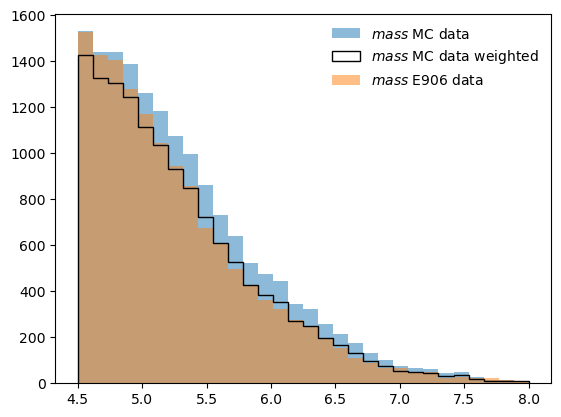

In [14]:
bins = np.linspace(4.5, 8.0, 31)
plt.hist(X0[:, 0], bins=bins, alpha=0.5, label=r'$mass$ MC data')
plt.hist(X0[:, 0], bins=bins, label=r'$mass$ MC data weighted', weights=weights, histtype='step', color='k')
plt.hist(X1[:, 0], bins=bins, alpha=0.5, label=r'$mass$ E906 data', weights=weight1)
plt.legend(frameon=False)
plt.show()

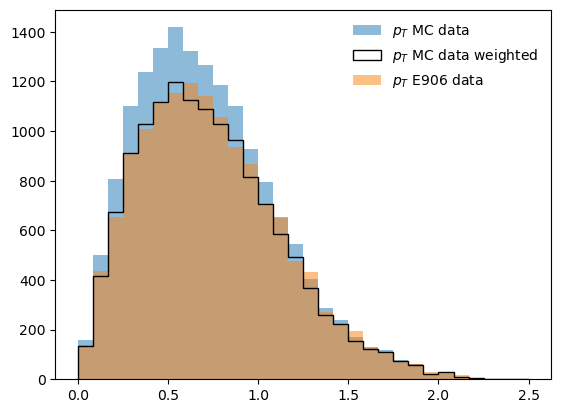

In [15]:
bins = np.linspace(0.0, 2.5, 31)
plt.hist(X0[:, 1], bins=bins, alpha=0.5, label=r'$p_{T}$ MC data')
plt.hist(X0[:, 1], bins=bins, label=r'$p_{T}$ MC data weighted', weights=weights, histtype='step', color='k')
plt.hist(X1[:, 1], bins=bins, alpha=0.5, label=r'$p_{T}$ E906 data', weights=weight1)
plt.legend(frameon=False)
plt.show()

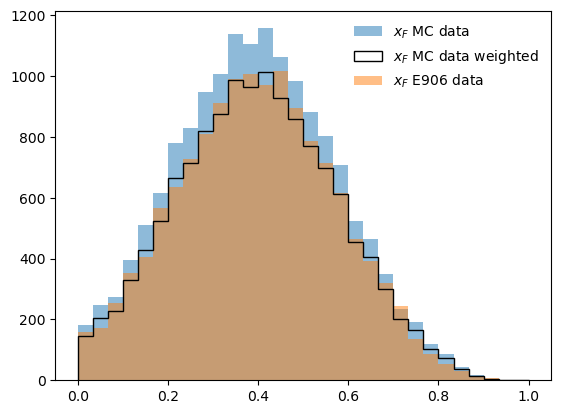

In [16]:
bins = np.linspace(0.0, 1.0, 31)
plt.hist(X0[:, 2], bins=bins, alpha=0.5, label=r'$x_{F}$ MC data')
plt.hist(X0[:, 2], bins=bins, label=r'$x_{F}$ MC data weighted', weights=weights, histtype='step', color='k')
plt.hist(X1[:, 2], bins=bins, alpha=0.5, label=r'$x_{F}$ E906 data', weights=weight1)
plt.legend(frameon=False)
plt.show()

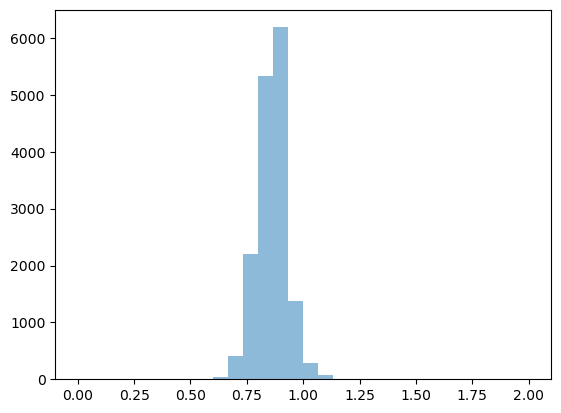

In [17]:
bins = np.linspace(0.0, 2.0, 31)
plt.hist(weights, bins=bins, alpha=0.5)
plt.show()